<a id="title_ID"></a>
# Beginner: Cutout of the TESS Full Frame Image Time Series using Python Requests

This notebook shows the user how to use the MAST programmatic interface to create a cutout of the small section of the TESS FFIs. For this example we will determine the RA and Dec for TOI 109.01, which is on TIC 29344935. We then perform a query to determine which sectors contain this RA and Dec, peform a cutout of the FFI time series, open the resulting target pixel files and plot the first image of each file with the WCS overlayed on the image.  

This tutorial shows the users how to do the following: use astroquery.catalogs to query the TIC, use the python requests module to query the available sectors, and python requests to obtain a ffi cutout with tesscut.


### Table of Contents 
  [Imports](#imports_ID) <br> 
  [Astroquery Search of the TIC](#catalog_ID) <br> 
  [Use Tesscut to get FFI Cutout](#tesscut_ID) <br>
  [Additional Resources](#resources_ID) <br> 
  [About this Notebook](#about_ID) 

## Import statements for this notebook.
<a id="imports_ID"></a>

In [2]:
import numpy as np
from astropy.io import fits
import requests
from astroquery.mast import Catalogs
import zipfile
from astropy.wcs import WCS
import matplotlib.pyplot as plt

%matplotlib inline

#This is the url we are using.
urlbase="https://mastdev.stsci.edu/tesscut/api/v0.1"

#Next line puts your mast api token in a useful variable for later.
#See https://auth.mast.stsci.edu/info
masttoken=%env MAST_DV_TOKEN

## Get RA and Dec of your Target Using Astroquery Catalogs
<a id="catalog_ID"></a>
Here we use the astroquery.mast Catalogs query_criteria function to request the RA and Dec of for the object with TIC ID = 261136679. This happens to be Pi Mensae. We collect the Right Ascension and Declination and store them in their own variables.  For good measure, we print out some of the resulting values from the catalog search in a table.  
<p>
Here we do a cone search using Catalogs.query_object on the TIC catalog. The advantage of doing this is that it gives us the nearby stars as well as the star we are looking for. The resulting table has the closest object first, we print out the ID and Jmag to ensure it matches the star ID we were looking for. 

In [89]:
ticid=261136679

#catalogData=Catalogs.query_criteria(catalog="Tic",ID=str(ticid))

starName="TIC "+str(ticid)
rad_search=6/60 #radius in degrees

catalogData = Catalogs.query_object(starName, radius=rad_search, catalog="TIC")
Ra=catalogData[0]['ra']
Dec=catalogData[0]['dec']

#Print out the first row in the table
print(catalogData[:5]['ID','Tmag','Jmag','ra','dec','objType'])

    ID     Tmag   Jmag      ra       dec     objType
--------- ------ ------ --------- ---------- -------
261136679  5.097  4.869 84.291198 -80.469143    STAR
261139071 13.995 13.495 84.257651  -80.46656    STAR
261136683 17.005 15.853 84.339545 -80.481056    STAR
261136676 17.059  16.48 84.334532 -80.454208    STAR
261139074 16.588 15.801 84.413579 -80.473656    STAR


In [90]:
#Create a list of nearby bright stars from the rest of the data for later.
bright=catalogData['Tmag']<14

#Make it a list of Ra, Dec pairs of the bright ones. So this is now a list of nearby bright stars.
nearby_stars=list(map(lambda x,y:[x,y], catalogData[bright]['ra'],catalogData[bright]['dec']))
len(nearby_stars)

13

## Use sector query to determine which TESS sectors have FFI data
<a id="catalog_ID"></a>
Using the TESS sector information service, we make a request to determine which sectors/cameras/CCDs contain data for this target. Remember that there is a set of FFIs for each Sector and those are broken up into 4 cameras which each have 4 CCDs.  We will do this with a radius=0 cone search to find only those FFI sets that contain the star of interest. You can make the query using a larger radius, which may matter if the star is near the edge of one of the CCDs.
<p>
Note, the request is returned in a json format. The 'results' key contains an array of dictionaries with the information we are looking for.  

In [60]:
myparams={"ra":Ra, "dec":Dec, "radius":"0m"}
url="https://mastdev.stsci.edu/tesscut/api/v0.1/sector"

requestData=requests.get(url=url,params=myparams)
print(requestData.headers.get('content-type'))

application/json; charset=UTF-8


In [61]:
sectors=requestData.json()['results']
sectors

[{'sectorName': 'tess-s0001-4-2', 'sector': '0001', 'camera': '4', 'ccd': '2'}]

Each element of the array shows one set of sector, camer and CCD that has data for the requested region of sky. 

<a id="tesscut_id"></a>
## Request a 10 x 15 pixel timeseries of FFI cutouts around specified RA and Dec.
This delivers a zipped file containing a cutout for each set of FFIs as listed above. It is also possible to request only one sector using the "sector" parameter.

In [77]:
myparams={"ra":Ra, "dec":Dec, "x":30, "y":35, 
           "units":"px","sector":"All"}
header={'Authorization': "token "+masttoken}

url="https://mastdev.stsci.edu/tesscut/api/v0.1/astrocut"

r=requests.get(url=url,params=myparams,headers=header)
#Check the content type.
print(r)
print(r.headers.get('content-type'))

<Response [200]>
application/zip


In [78]:
open('astrocut.zip', 'wb').write(r.content)

9885450

### Open the zip file so we can get at the file.
We use python's zipfile to unzip the file, but this could also be done using unzip from the command line. In many cases you will get more than one file, one for each sector that observed the star.  If you ask for a large cutout, you might also get more than one because the pixels are on more than one CCD.  In this case, we got back one file. The name contains the RA and Dec as well as the sector number, camera and chip. 

In [79]:
zipRef=zipfile.ZipFile('astrocut.zip','r')
zipRef.extractall('.')
zipRef.close()
cutoutnames = zipRef.namelist()
print(cutoutnames)

['tess-s0001-4-2_84.291198_-80.469143_35x30_astrocut.fits']


### Inspect the contents the file.
Use the fits.info function to see the contents of the file. Notice that it has three extensions just like a target pixel file. Most of the interesting information is in the PIXELS extension.

In [80]:
file1=cutoutnames[0]
fits.info(file1)

Filename: tess-s0001-4-2_84.291198_-80.469143_35x30_astrocut.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  PIXELS        1 BinTableHDU    244   1282R x 12C   [D, E, J, 1050J, 1050E, 1050E, 1050E, 1050E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU       143   (35, 30)   float64   


In [81]:
hdu1=fits.open(file1)
hdu1[1].columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'RAW_CNTS'; format = '1050J'; unit = 'count'; null = -1; disp = 'I8'; dim = '(35, 30)'
    name = 'FLUX'; format = '1050E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(35, 30)'
    name = 'FLUX_ERR'; format = '1050E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(35, 30)'
    name = 'FLUX_BKG'; format = '1050E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(35, 30)'
    name = 'FLUX_BKG_ERR'; format = '1050E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(35, 30)'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'POS_CORR1'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'POS_CORR2'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'FFI_FILE'; format = '38A'; unit = 'pixel'
)

<a id="plot_image"></a>
## Plot the First Image of the Data


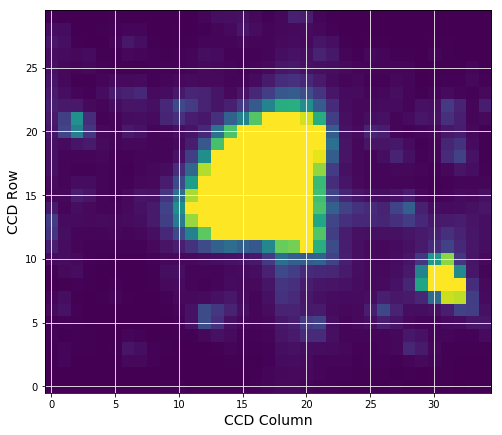

In [82]:
first_image=hdu1[1].data['FLUX'][0]
fig = plt.figure(figsize=(8,8))
plt.imshow(first_image, origin='lower', cmap=plt.cm.viridis, vmax=np.percentile(first_image,92),vmin=np.percentile(first_image,5))
plt.xlabel('CCD Column',fontsize=14)
plt.ylabel('CCD Row',fontsize=14)
plt.grid(axis='both',color='white', ls='solid')

### Add a WCS to the image and mark the requested star as well as nearby stars.
We use the WCS in the header to place a red dot on the image for the catalog position of the star on the figure as a demonstration of the WCS. Remember that the WCS is based on the WCS stored in the FFI file for the central part of the time series and there can be some motion during a sector of observation. 

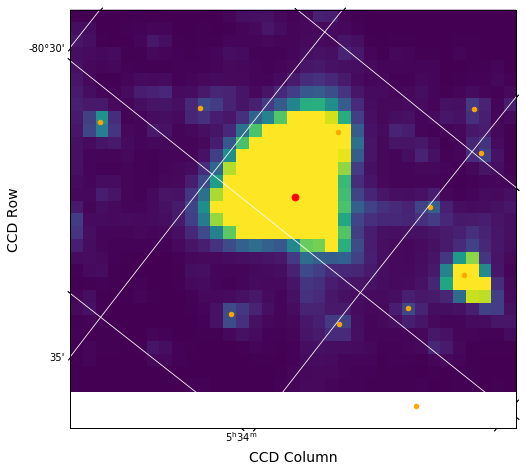

In [88]:
wcs=WCS(hdu1[2].header)

fig = plt.figure(figsize=(8,8))
fig.add_subplot(111, projection=wcs)
plt.imshow(first_image, origin='lower', cmap=plt.cm.viridis, vmax=np.percentile(first_image,92),vmin=np.percentile(first_image,5))
plt.xlabel('CCD Column',fontsize=14)
plt.ylabel('CCD Row',fontsize=14)
plt.grid(axis='both',color='white', ls='solid')

starloc=wcs.all_world2pix([[Ra,Dec]],0)  #Second is origin
plt.scatter(starloc[0,0],starloc[0,1],s=45,color='red')

#Plot nearby stars as well, which we created using our Catalog call above.
nearbyloc=wcs.all_world2pix(nearby_stars[1:],0)
plt.scatter(nearbyloc[1:,0],nearbyloc[1:,1],s=20,color='orange')

<a id="resources_ID"></a>
## Additional Resources
[TESScut API Documentation](https://mast.stsci.edu/tesscut/)<br>
[Astrocut Documentation](https://astrocut.readthedocs.io/en/latest/)<br>
[TESS Homepage](https://archive.stsci.edu/tess)


<a id="about_ID"></a>
## About this Notebook
**Author:** Susan E. Mullally, STScI Archive Scientist
<br>**Updated On:** 2018-11-13

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 